In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from fastai import *
from fastai.text import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print(torch.cuda.get_device_name(device=None))

GeForce GTX 1050 Ti


# Data Science Task
1. Build a ML model which can predict the `sentiment`
2. Apply the model to a single restuarant, to reveal key aspects which drive overall customer `perception`
3. Anything else you think might be interesting!

In [2]:
path = untar_data(URLs.YELP_REVIEWS)
df_train = pd.read_csv(path/'train.csv', header=None, names=['rating', 'text']) \
             .sample(frac=0.01, random_state=1)
df_test = pd.read_csv(path/'test.csv', header=None, names=['rating', 'text']) \
            .sample(frac=0.01, random_state=1)

* Taking sample set for development

In [3]:
print(df_train.shape, df_test.shape)
df_train.head()

(6500, 2) (500, 2)


,rating,text
21194,1,Thank you for all the emails you sent me on my...
373117,4,"I, myself, and vietnamese and have tried all d..."
470627,3,"3.5 stars.\n\nI have had BFG on my list of \""m..."
256672,3,Edamame with truffle salt was great; really li...
465495,4,So I'm running errands before I go back to th...


In [4]:
# First review
df_train['text'][21194][:500]

'Thank you for all the emails you sent me on my review! I was surprised at how many responses I recieved from people searching for the right dentist..\\nI shared my new dentist information and even got some movie tickets from my dentist for the referrals!\\nI find it funny how since I wrote this review how many people have reviewed with 5 stars... They must have a lot of friends and family! \\nI hope everyone reads my review and picks the right dentist for your needs!\\nHappy Holidays'

### Split into `training`, `validation` and `hold-out` test set (df_test)

In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and validation set
df_trn, df_val = train_test_split(df_train, stratify=df_train['rating'],
                                  test_size=0.2, random_state=1)
print(df_trn.shape, df_val.shape)

(5200, 2) (1300, 2)


In [6]:
%%time
df_trn.to_csv(path / 'train_sample.csv')
df_val.to_csv(path / 'val_sample.csv')
df_test.to_csv(path / 'test_sample.csv')

Wall time: 227 ms


In [7]:
path.ls()

[WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/models'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/readme.txt'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/test.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/test_df_sample.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/test_sample.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/train.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/train_df_sample.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/train_sample.csv'),
 WindowsPath('C:/Users/Luke/.fastai/data/yelp_review_full_csv/val_sample.csv')]

### Tokenization
* The first step of processing we make the texts go through is to split the raw sentences into words, or `tokens`.

In [8]:
%%time
data = TextClasDataBunch.from_csv(path, 'train_sample.csv', 
                                  text_cols='text', label_cols='rating')
data.show_batch()

text,target
"xxbos xxmaj dear xxmaj pastavino , xxmaj chef xxmaj marc , and staff : \n xxmaj why did you screw me ? i walked out of your restaurant feeling dirty , ashamed , and ultimately screwed . \n 5-star reviews left and right , family members telling me it is impeccable , xxunk - xxunk of a chef painting a picture of a truly delicious xxmaj italian meal",2
"xxbos xxmaj aesthetically speaking , the hotel is pretty cool . a bit of swank in the lobby with the new furniture ; the casino is all right , but certainly not the fanciest in the world . xxmaj the rooms are , for the most part , well - appointed and comfortable . xxmaj we had a xxunk floor view room in the south tower and it suited us",2
"xxbos i was the first patron in the restaurant when i arrived at 6 pm xxmaj tues . , but the place quickly filled up and the sushi bar was soon at xxunk capacity . xxmaj patrons are mostly locals w / some out of towners from listening to random conversations here and there . xxmaj the sushi bar is just a small part of the overall square footage of",3
"xxbos xxmaj wow . xxmaj two stars because the food is always delicious but what the hell has happened to the service ? \n \n i was n't even going to write this review because i asked for the manager ( xxmaj aaron , great guy ) and his empathy blew my mind . \n \n 1 . xxmaj my two male friends arrived at 7:30 on xxmaj",2
"xxbos xxmaj let me preface the following review by saying that if i did n't absolutely have a terrible experience , i would n't have said anything . xxmaj this review is also concerning their window xxup only . i really wanted to go to their restaurant the next time we go to xxmaj new xxmaj york , but if this window is a representation of xxmaj serendipity 3 's",1


Wall time: 18.1 s


### Numericalization into `vocab`

* Creating unique tokens for all words
* Top 60,000 used by default - unknown token `xxunk` used for remainders
* Special characters are tokenised (spaces, punctuation, new lines)
* `xxbos` is the token for beginning of sentence etc..

In [9]:
# Top 10 words
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [10]:
# Example tokenised review
data.train_ds[0][0].text[:200]

'xxbos xxmaj my rating is based on the over all experience . i enjoyed the food , it was fresh and tasty , and there was plenty . i went with a friend of mine , the only real reason for not giving it a'

In [11]:
# The model needs numbers, so tokens are mapped onto their index
data.train_ds[0][0].data[:10]

array([  2,   5,  24, 977,  19, 654,  33,  10, 118,  58], dtype=int64)

### Language Model
* Model `AWD_LSTM` is pretrained on a processed subset of wikipedia `wikitext-103`
* This RNN model is trained to predict what the next word in the sequence is
* It has a recurrent structure and a hidden state (updated each time it sees a new word), which contains information about the sentence

For sentiment analysis we are creating two models:
1. A language model `data_lm` (fine-tuned encoder, no labels)
2. A text classification model `data_clas` (with labels)

In [12]:
# Decrease batchsize if GPU can't handle the load
bs = 24       # range 12 - 48

In [13]:
%%time
# Language Model data
data_lm = TextLMDataBunch.from_df(path, df_trn, df_val)

print('Training and validation shape:\n', df_trn.shape, df_val.shape)
data_lm.show_batch(rows=1)

Training and validation shape:
 (5200, 2) (1300, 2)


idx,text
0,"xxmaj also , they 're so money hungry they 'll start giving you lap dances without asking you and then make you pay them . xxmaj it 's pathetic . xxmaj this place is n't really even on the strip either which i advise everyone to never leave the strip if you 're on vacation . xxmaj it 's location is creepy as heck . xxmaj for a minute ,"


Wall time: 14.5 s


In [26]:
# Transfer learning Model AWD_LSTM pre-trained on WikiText103

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [30]:
# Only the last layer is unfrozen during training
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 12568]          5,039,768  True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 5,039,768
Total trainable params: 5,039,768
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss func

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Wall time: 26.9 s


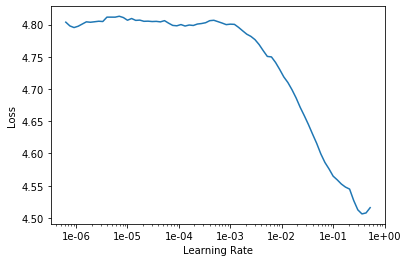

In [155]:
%%time
# Find best learning rate from slope
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [28]:
# Training/fine-tuning final layer to yelp reviews

learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.167284,3.977749,0.269013,01:14


* `Accuracy` here is the ability for the model to predict the next word in the sequence

In [29]:
%%time
# Run until valid_loss comes down to training_loss (past this is overfitting to training set)

learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.903922,3.958114,0.270406,01:13
1,3.873710,3.928061,0.272272,01:12
2,3.803656,3.908676,0.274170,01:12
3,3.756115,3.901146,0.274652,01:13
4,3.736504,3.900128,0.274558,01:12


Wall time: 6min 4s


In [52]:
learn.save_encoder('fine_tuned_enc')

* Now, the encoder is fine tuned to `Yelp Reviews`
* The encoder can be used to predict the next word in a sentence
* The next step is to remove the final layers of the encoder, and replace them with a classification/regression model

In [37]:
data_lm.train_ds.inner_df.shape

(5200, 2)

In [38]:
data_lm.valid_ds.inner_df.shape

(1300, 2)

### Predicting `next word` with language model

In [43]:
learn.predict("I really loved the restaurant, the food was")

'I really loved the restaurant, the food was good'

In [40]:
learn.predict("I hated the restaurant, the food tasted")

'I hated the restaurant, the food tasted horrible'

### Generating fake yelp reviews

In [50]:
text = "The food is good but the waitor"
text = 'This was definitely one of the highlights'
words = 40

print(learn.predict(text, words, temperature=0.75))

This was definitely one of the highlights of the VIP experience on the evening , at a two - hour show on Monday , 4 November . The show included an all - played night with Mike Tyson and Mike


# Classification Model for `Sentiment Analysis`

In [14]:
%%time
# 2. Classification Model
data_clas = TextClasDataBunch.from_df(path, df_trn, df_val, vocab=data_lm.train_ds.vocab)
data_clas.show_batch(rows=1)

text,target
"xxbos xxmaj dear xxmaj pastavino , xxmaj chef xxmaj marc , and staff : \n xxmaj why did you screw me ? i walked out of your restaurant feeling dirty , ashamed , and ultimately screwed . \n 5-star reviews left and right , family members telling me it is impeccable , xxunk - xxunk of a chef painting a picture of a truly delicious xxmaj italian meal",2


Wall time: 13.8 s


* Instantiate new learner, and load embeddings from fine-tuning

In [15]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [16]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 120.13 MiB (GPU 0; 4.00 GiB total capacity; 2.35 GiB already allocated; 42.37 MiB free; 188.80 MiB cached)

In [ ]:
learn_c.recorder.plot()

In [ ]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))